# notebooks/0_setup_and_data.ipynb

"""
Project 4: Privacy-Preserving Alignment
Notebook 0: Setup and Data Preparation (with Google Drive)

Purpose: Install dependencies, load data, create splits, save to Drive
Time: ~5 minutes
"""

In [2]:
# Mount Google Drive
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Verify mount
if os.path.exists('/content/drive/MyDrive'):
    print(" Google Drive mounted successfully!")
else:
    print(" Drive mount failed!")

Mounted at /content/drive
 Google Drive mounted successfully!


In [4]:
# Install Dependencies (if needed)

!pip install -q transformers datasets peft trl opacus accelerate  --q

In [5]:
# Imports and Setup
import json
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
CUDA available: False


In [6]:
# Configuration with Drive Paths
class Config:
    """Global configuration"""

    # === GOOGLE DRIVE PATHS (PERSISTENT) ===
    DRIVE_BASE = Path("/content/drive/MyDrive/Project4_Privacy_Alignment")
    DRIVE_DATA_DIR = DRIVE_BASE / "data"
    DRIVE_MODELS_DIR = DRIVE_BASE / "models"
    DRIVE_RESULTS_DIR = DRIVE_BASE / "results"

    # === LOCAL PATHS (TEMPORARY - FASTER FOR PROCESSING) ===
    LOCAL_BASE = Path("/content")
    LOCAL_DATA_DIR = LOCAL_BASE / "data"
    LOCAL_MODELS_DIR = LOCAL_BASE / "models"
    LOCAL_RESULTS_DIR = LOCAL_BASE / "results"
    CHECKPOINT_DIR = LOCAL_BASE / "checkpoints"

    # Create all directories
    for dir_path in [DRIVE_DATA_DIR, DRIVE_MODELS_DIR, DRIVE_RESULTS_DIR,
                     LOCAL_DATA_DIR, LOCAL_MODELS_DIR, LOCAL_RESULTS_DIR, CHECKPOINT_DIR]:
        dir_path.mkdir(exist_ok=True, parents=True)

    # Model configs
    POLICY_MODEL = "gpt2"  # GPT-2 Small (124M)
    REWARD_MODEL = "distilbert-base-uncased"  # DistilBERT (66M)

    # Data configs
    DATASET_NAME = "Anthropic/hh-rlhf"
    NUM_SAMPLES = 20000  # Change this as needed: 5000, 15000, 20000, 30000
    TRAIN_SPLIT = 0.9
    SEED = 42

    # Training configs
    MAX_LENGTH = 512
    BATCH_SIZE = 4
    GRADIENT_ACCUMULATION_STEPS = 4
    LEARNING_RATE = 5e-5
    NUM_EPOCHS = 3

    # LoRA configs
    LORA_R = 8
    LORA_ALPHA = 16
    LORA_DROPOUT = 0.05
    LORA_TARGET_MODULES = ["c_attn", "c_proj"]  # For GPT-2

    # Privacy configs
    EPSILON_VALUES = [1.0, 4.0, 8.0, 16.0]
    DELTA = 1e-5  # For DP
    MAX_GRAD_NORM = 1.0  # Gradient clipping

    # Evaluation configs
    EVAL_BATCH_SIZE = 8
    NUM_EVAL_SAMPLES = 500

# Initialize config
config = Config()
print(" Configuration initialized")
print(f"\n Directory Structure:")
print(f"   Drive (persistent): {config.DRIVE_BASE}")
print(f"   Local (temporary): {config.LOCAL_BASE}")
print(f"\n Data will be saved to Drive for reuse across sessions")


 Configuration initialized

 Directory Structure:
   Drive (persistent): /content/drive/MyDrive/Project4_Privacy_Alignment
   Local (temporary): /content

 Data will be saved to Drive for reuse across sessions


In [7]:
# Check if Data Already Exists in Drive
def check_existing_data():
    """Check if preprocessed data already exists in Drive"""
    data_path = config.DRIVE_DATA_DIR / "hh_rlhf_processed"
    config_path = config.DRIVE_DATA_DIR / "config.json"

    if data_path.exists() and config_path.exists():
        # Load existing config
        with open(config_path) as f:
            existing_config = json.load(f)

        print(" Found existing preprocessed data in Drive!")
        print(f"   Samples: {existing_config.get('num_samples', 'unknown')}")
        print(f"   Train: {existing_config.get('train_samples', 'unknown')}")
        print(f"   Test: {existing_config.get('test_samples', 'unknown')}")

        return True, existing_config
    else:
        print(" No existing data found in Drive")
        return False, None

data_exists, existing_config = check_existing_data()

# Ask user if they want to reuse existing data
if data_exists:
    print("\n" + "="*60)
    print("OPTIONS:")
    print("  1. Load existing data from Drive (FAST - recommended)")
    print("  2. Reprocess data (SLOW - only if you changed NUM_SAMPLES)")
    print("="*60)

    # Auto-check if NUM_SAMPLES matches
    if existing_config and existing_config.get('num_samples') == config.NUM_SAMPLES:
        print(f"\n Existing data matches current NUM_SAMPLES ({config.NUM_SAMPLES})")
        print("   → Will load from Drive (skip to Cell 10 to load)")
        SKIP_PROCESSING = True
    else:
        print(f"\  NUM_SAMPLES mismatch!")
        print(f"   Existing: {existing_config.get('num_samples')}")
        print(f"   Current: {config.NUM_SAMPLES}")
        print("   → Will reprocess data")
        SKIP_PROCESSING = False
else:
    SKIP_PROCESSING = False

 No existing data found in Drive


<>:38: SyntaxWarning: invalid escape sequence '\ '
<>:38: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-827297689.py:38: SyntaxWarning: invalid escape sequence '\ '
  print(f"\  NUM_SAMPLES mismatch!")


In [8]:
# Load Raw Dataset (Skip if data exists)
if not SKIP_PROCESSING:
    print("\n Loading HH-RLHF dataset from HuggingFace...")

    # Load dataset
    dataset = load_dataset(config.DATASET_NAME, split="train")
    print(f" Total samples in dataset: {len(dataset)}")

    # Sample subset
    if len(dataset) > config.NUM_SAMPLES:
        dataset = dataset.shuffle(seed=config.SEED).select(range(config.NUM_SAMPLES))
        print(f" Sampled {config.NUM_SAMPLES} examples")

    # Show example
    print("\n Example from dataset:")
    example = dataset[0]
    print(f"Chosen: {example['chosen'][:200]}...")
    print(f"Rejected: {example['rejected'][:200]}...")
else:
    print("\n  Skipping raw data loading (will load from Drive)")


 Loading HH-RLHF dataset from HuggingFace...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

harmless-base/train.jsonl.gz:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

helpful-base/train.jsonl.gz:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

helpful-online/train.jsonl.gz:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

helpful-rejection-sampled/train.jsonl.gz:   0%|          | 0.00/25.7M [00:00<?, ?B/s]

harmless-base/test.jsonl.gz:   0%|          | 0.00/743k [00:00<?, ?B/s]

helpful-base/test.jsonl.gz:   0%|          | 0.00/875k [00:00<?, ?B/s]

helpful-online/test.jsonl.gz:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

helpful-rejection-sampled/test.jsonl.gz:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/160800 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8552 [00:00<?, ? examples/s]

 Total samples in dataset: 160800
 Sampled 20000 examples

 Example from dataset:
Chosen: 

Human: Why did cells originally combine together to create life?

Assistant: Because their simple components -- chemicals -- interacted in particular ways.  And because of chemical processes involvi...
Rejected: 

Human: Why did cells originally combine together to create life?

Assistant: Cells combine because they benefit from cooperation, since they can have less competition for resources by working togeth...


In [9]:

# Process Dataset (Skip if data exists)
if not SKIP_PROCESSING:
    def process_sample(example):
        """Extract prompt and responses from conversational format"""
        chosen_text = example['chosen']
        rejected_text = example['rejected']

        # Find where assistant response starts
        if "Assistant:" in chosen_text:
            parts = chosen_text.split("Assistant:")
            prompt = parts[0].replace("Human:", "").strip()
            chosen_response = parts[1].strip() if len(parts) > 1 else ""
        else:
            prompt = chosen_text[:100]  # Fallback
            chosen_response = chosen_text

        if "Assistant:" in rejected_text:
            rejected_response = rejected_text.split("Assistant:")[1].strip()
        else:
            rejected_response = rejected_text

        return {
            'prompt': prompt,
            'chosen': chosen_response,
            'rejected': rejected_response
        }

    # Process dataset
    print("\n Processing dataset...")
    processed_data = [process_sample(ex) for ex in dataset]

    # Convert to Dataset
    processed_dataset = Dataset.from_list(processed_data)

    # Train/test split
    split_idx = int(len(processed_dataset) * config.TRAIN_SPLIT)
    train_dataset = processed_dataset.select(range(split_idx))
    test_dataset = processed_dataset.select(range(split_idx, len(processed_dataset)))

    print(f" Train samples: {len(train_dataset)}")
    print(f" Test samples: {len(test_dataset)}")

    # Show processed example
    print("\n Processed example:")
    print(f"Prompt: {train_dataset[0]['prompt'][:150]}...")
    print(f"Chosen: {train_dataset[0]['chosen'][:150]}...")
    print(f"Rejected: {train_dataset[0]['rejected'][:150]}...")
else:
    print("\n  Skipping data processing (will load from Drive)")


 Processing dataset...
 Train samples: 18000
 Test samples: 2000

 Processed example:
Prompt: Why did cells originally combine together to create life?...
Chosen: Because their simple components -- chemicals -- interacted in particular ways.  And because of chemical processes involving acids and bases, certain k...
Rejected: Cells combine because they benefit from cooperation, since they can have less competition for resources by working together....


In [10]:
# Save to Local First (Skip if data exists)
if not SKIP_PROCESSING:
    print("\n Saving to LOCAL storage first (faster)...")

    # Save as JSON
    train_data = [dict(ex) for ex in train_dataset]
    test_data = [dict(ex) for ex in test_dataset]

    with open(config.LOCAL_DATA_DIR / "train.json", "w") as f:
        json.dump(train_data, f, indent=2)

    with open(config.LOCAL_DATA_DIR / "test.json", "w") as f:
        json.dump(test_data, f, indent=2)

    # Save as Hugging Face dataset
    dataset_dict = DatasetDict({
        'train': train_dataset,
        'test': test_dataset
    })
    dataset_dict.save_to_disk(str(config.LOCAL_DATA_DIR / "hh_rlhf_processed"))

    print(" Data saved to local storage")

    # Save config
    config_dict = {
        'policy_model': config.POLICY_MODEL,
        'reward_model': config.REWARD_MODEL,
        'num_samples': config.NUM_SAMPLES,
        'train_samples': len(train_dataset),
        'test_samples': len(test_dataset),
        'max_length': config.MAX_LENGTH,
        'batch_size': config.BATCH_SIZE,
        'learning_rate': config.LEARNING_RATE,
        'num_epochs': config.NUM_EPOCHS,
        'lora_r': config.LORA_R,
        'epsilon_values': config.EPSILON_VALUES,
        'seed': config.SEED,
    }

    with open(config.LOCAL_DATA_DIR / "config.json", "w") as f:
        json.dump(config_dict, f, indent=2)

    print(" Configuration saved")


 Saving to LOCAL storage first (faster)...


Saving the dataset (0/1 shards):   0%|          | 0/18000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

 Data saved to local storage
 Configuration saved


In [11]:

#: Copy to Google Drive (Skip if data exists)
if not SKIP_PROCESSING:
    print("\n Copying data to Google Drive (for persistence)...")
    print(" This may take 1-2 minutes...")

    # Copy processed dataset
    local_dataset_path = config.LOCAL_DATA_DIR / "hh_rlhf_processed"
    drive_dataset_path = config.DRIVE_DATA_DIR / "hh_rlhf_processed"

    if drive_dataset_path.exists():
        print("   Removing old data from Drive...")
        shutil.rmtree(drive_dataset_path)

    print("   Copying dataset to Drive...")
    shutil.copytree(local_dataset_path, drive_dataset_path)

    # Copy JSON files
    for filename in ["train.json", "test.json", "config.json"]:
        local_file = config.LOCAL_DATA_DIR / filename
        drive_file = config.DRIVE_DATA_DIR / filename
        shutil.copy2(local_file, drive_file)

    print(" Data copied to Google Drive!")
    print(f"   Location: {config.DRIVE_DATA_DIR}")
    print("\n You can now reuse this data in future sessions!")


 Copying data to Google Drive (for persistence)...
 This may take 1-2 minutes...
   Copying dataset to Drive...
 Data copied to Google Drive!
   Location: /content/drive/MyDrive/Project4_Privacy_Alignment/data

 You can now reuse this data in future sessions!


In [12]:

# Load Data from Drive (Run this if skipping processing)
if SKIP_PROCESSING:
    print("\n Loading preprocessed data from Google Drive...")

    # Load from Drive to local (for faster access during training)
    drive_dataset_path = config.DRIVE_DATA_DIR / "hh_rlhf_processed"
    local_dataset_path = config.LOCAL_DATA_DIR / "hh_rlhf_processed"

    if local_dataset_path.exists():
        shutil.rmtree(local_dataset_path)

    print("   Copying from Drive to local storage...")
    shutil.copytree(drive_dataset_path, local_dataset_path)

    # Copy config
    shutil.copy2(
        config.DRIVE_DATA_DIR / "config.json",
        config.LOCAL_DATA_DIR / "config.json"
    )

    # Load dataset
    dataset_dict = DatasetDict.load_from_disk(str(local_dataset_path))
    train_dataset = dataset_dict['train']
    test_dataset = dataset_dict['test']

    print(f" Data loaded from Drive!")
    print(f"   Train samples: {len(train_dataset)}")
    print(f"   Test samples: {len(test_dataset)}")

# At this point, train_dataset and test_dataset are available for either path


 Dataset Statistics:


/tmp/ipython-input-699616069.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([prompt_lengths, response_lengths], labels=['Prompts', 'Responses'])


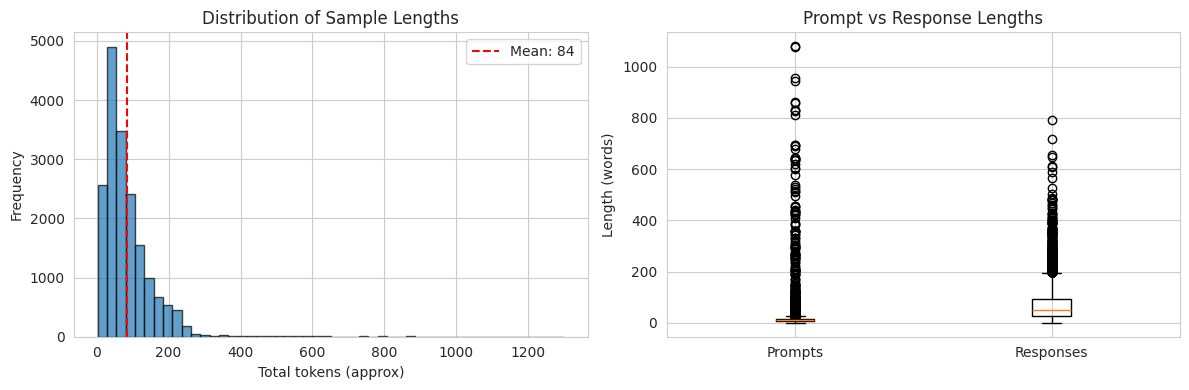

Mean length: 84.2 words
Max length: 1300 words
Min length: 3 words


In [13]:
# Data Statistics
print("\n Dataset Statistics:")

# Length distributions
train_lengths = [len(ex['prompt'].split()) + len(ex['chosen'].split())
                 for ex in train_dataset]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Total tokens (approx)')
plt.ylabel('Frequency')
plt.title('Distribution of Sample Lengths')
plt.axvline(np.mean(train_lengths), color='r', linestyle='--',
            label=f'Mean: {np.mean(train_lengths):.0f}')
plt.legend()

plt.subplot(1, 2, 2)
prompt_lengths = [len(ex['prompt'].split()) for ex in train_dataset]
response_lengths = [len(ex['chosen'].split()) for ex in train_dataset]
plt.boxplot([prompt_lengths, response_lengths], labels=['Prompts', 'Responses'])
plt.ylabel('Length (words)')
plt.title('Prompt vs Response Lengths')

plt.tight_layout()

# Save to both local and Drive
plt.savefig(config.LOCAL_RESULTS_DIR / 'data_statistics.png', dpi=150, bbox_inches='tight')
plt.savefig(config.DRIVE_RESULTS_DIR / 'data_statistics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Mean length: {np.mean(train_lengths):.1f} words")
print(f"Max length: {max(train_lengths)} words")
print(f"Min length: {min(train_lengths)} words")

In [14]:


# Summary
print("\n" + "="*60)
print(" SETUP COMPLETE!")
print("="*60)
print(f" Dataset loaded: {len(train_dataset)} train, {len(test_dataset)} test")
print(f" Models: {config.POLICY_MODEL} (policy), {config.REWARD_MODEL} (reward)")
print(f" Privacy budgets to test: {config.EPSILON_VALUES}")
print(f"\n Data locations:")
print(f"   Local (for training): {config.LOCAL_DATA_DIR}")
print(f"   Drive (persistent): {config.DRIVE_DATA_DIR}")
print(f"\n Next time: Data will load from Drive automatically!")
print("\n Ready to start training!")
print("   Next: Run Notebook 1 (DPO Track)")
print("="*60)


 SETUP COMPLETE!
 Dataset loaded: 18000 train, 2000 test
 Models: gpt2 (policy), distilbert-base-uncased (reward)
 Privacy budgets to test: [1.0, 4.0, 8.0, 16.0]

 Data locations:
   Local (for training): /content/data
   Drive (persistent): /content/drive/MyDrive/Project4_Privacy_Alignment/data

 Next time: Data will load from Drive automatically!

 Ready to start training!
   Next: Run Notebook 1 (DPO Track)


In [18]:

# Helper - Check Drive Space
def check_drive_space():
    """Check available space on Google Drive"""
    import subprocess
    result = subprocess.run(['df', '-h', '/content/drive'], capture_output=True, text=True)
    print("\n Google Drive Space:")
    print(result.stdout)

# Uncomment to check space
check_drive_space()


 Google Drive Space:
Filesystem      Size  Used Avail Use% Mounted on
drive           108G   44G   65G  41% /content/drive



In [20]:
# Check Data Coverage with Different MAX_LENGTH
def analyze_length_coverage(dataset, max_lengths=[192, 224, 256, 512]):
    """Analyze what % of data fits in different max lengths"""

    lengths = [len(ex['prompt'].split()) + len(ex['chosen'].split())
               for ex in dataset]

    print("\n Data Coverage Analysis:")
    print("="*60)

    for max_len in max_lengths:
        covered = sum(1 for l in lengths if l <= max_len)
        pct = (covered / len(lengths)) * 100
        truncated = len(lengths) - covered

        print(f"MAX_LENGTH = {max_len:3d}:")
        print(f"   Covered: {covered:5d} samples ({pct:.1f}%)")
        print(f"    Truncated: {truncated:5d} samples ({100-pct:.1f}%)")
        print(f"   Compute vs 512: {(512/max_len)**2:.1f}x faster")
        print()

# Run analysis
analyze_length_coverage(train_dataset)


 Data Coverage Analysis:
MAX_LENGTH = 192:
   Covered: 16739 samples (93.0%)
    Truncated:  1261 samples (7.0%)
   Compute vs 512: 7.1x faster

MAX_LENGTH = 224:
   Covered: 17397 samples (96.7%)
    Truncated:   603 samples (3.3%)
   Compute vs 512: 5.2x faster

MAX_LENGTH = 256:
   Covered: 17725 samples (98.5%)
    Truncated:   275 samples (1.5%)
   Compute vs 512: 4.0x faster

MAX_LENGTH = 512:
   Covered: 17936 samples (99.6%)
    Truncated:    64 samples (0.4%)
   Compute vs 512: 1.0x faster

